# RNN and LSTM
## RNN
What are sequences? By definition, a sequence has the following properties:
- Elements in a sequence can be repeated.
- The order of elements matters.
- A sequence may be of variable length.

In sequence modeling, we want to output the sequence that has the highest probability, where each element has a probability. For example, consider a text sequence $S=$ "Math is hard" and we assume each word is independent. Then the probability of the sequence $S$ is $P(S)=P(\text{Math})\times P(\text{is}) \times P(\text{hard})$. Since the word "is" is frequently used word, let $P(\text{is})=0.039$ and $P(\text{Math})=0.0001$, $P(\text{hard})=0.0021$. Now, if we want to a sequence of three words that has the highest probability, then the sequence may look like "hard hard hard".

If we think more deeply, then one can realize that such way of defining the probabilities of words is unrealistic, since the table of probabilities might be extremely large. The probability of a word is too small that might blow the precision of computer. Moreover, the words are not independent and the different order of words means different. Thus, this is not a good sequence model.

A **recurrent neural network**, or called RNN, is a network specialized for processing a sequence of data. The structure of RNN is illustrated below. Each hidden state is the output of the activation $\sigma$, which is a function of the previous hidden state $h_{t-1}$ and the intput $x_t$. It's possible that the hidden state $h_t$ is the output of $y_t$. For time $t=0$ to $t=T$, we keep update our hidden state and output by the recurrence relation, where $W_{in},W_{out},W_h$ are weight matrices and $b_{h},b_{in}$ are bias vectors. Note that the weight matrices are **reused** at every time step. Also, under this structure, the previous states and inputs affect the outputs; the afterwards hidden states and inputs cannot affect the previous states and outputs.

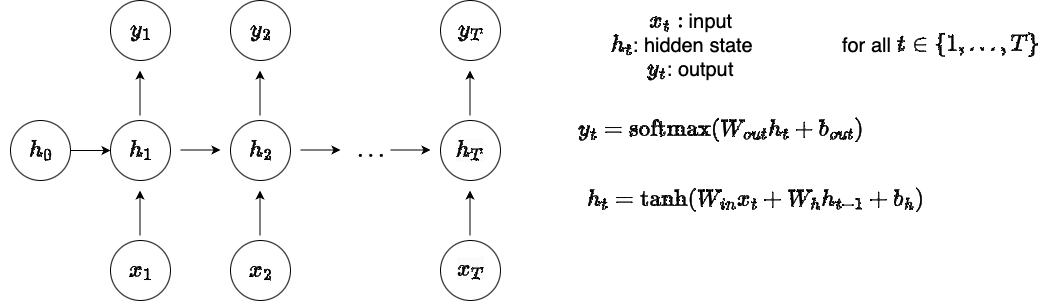

RNN is mathematically defined as a dynamic system:
$$
\begin{aligned}
& y_t=\text{softmax}(W_{out}h_t+b_{out}) \\
& h_t = \tanh(W_{in}x_t+W_hh_{t-1}+b_h)=\tanh([x_t,h_{t-1}]W+b_h)
\end{aligned}
$$
To coincide with the notation of `nn.Linear` in PyTorch, we re-write the system:
$$
\begin{aligned}
& y_t=\text{softmax}(h_t W_{out}^T+b_{out}) \\
& h_t = \tanh(x_t W_{in}^T+h_{t-1}W_h^T+b_h)=\tanh([x_t,h_{t-1}]W^T+b_h)
\end{aligned}
$$
where ^T denotes the transpose. In practice, we usually concatenate $W_{in}$ and $W_h$ vertically, denoted $W$ and concatenate $x_t$ and $h_{t-1}$ horizontally with the symbol $[x_t,h_{t-1}]$.

Let's write down the dimension of $W^T$ and $[x_t,h_{t-1}]$ explicitly.
- $h_t,y_t\in\mathbb{R}^{1\times d}$.
- $x_t\in\mathbb{R}^{1\times n}$
- $W_{in}^T\in\mathbb{R}^{n\times d}$
- $h_{t-1}\in\mathbb{R}^{1\times d}$
- $W_h^T\in\mathbb{R}^{d\times d}$.

Then $[x_t,h_{t-1}]\in\mathbb{R}^{1\times(n+d)}$ and $W^T\in\mathbb{R}^{(n+d)\times d}$. For a batch of $m$ data, the input is of shape $[m,1,n]$ and $h_t$ is of shape $[m,1,d]$.

### Backpropagation Through Time

Backpropagation Through Time (BTPP) is the application of the Backpropagation training algorithm to recurrent neural network applied to sequence data like a time series. BPTT works by **unrolling all input timesteps**. Each timestep has one input timestep, one copy of the network, and one output. Errors are then calculated and accumulated for each timestep. The network is rolled back up and the weights are updated.

Let $L(W_{in},W_{h},W_{out},b_h,b_{out})=L(\theta)=\sum_{t=1}^T L^{(t)}(\theta) $ be our loss function (ignoring the constant $\frac{1}{n}$). The partial derivative of $L^{(t)}(\theta)$ with respect to $W_{h}$ is expanded with chain rule
$$
\frac{\partial L^{(t)}}{\partial W_{h}}=\frac{\partial L^{(t)}}{\partial y_t}\frac{\partial y_t}{\partial h_t}\left( \sum_{k=1}^t \frac{\partial h_t}{\partial h_k}\frac{\partial h_k}{\partial W_{h}} \right)
$$
where
$$
\frac{\partial h_t}{\partial h_k} = \prod_{i=k+1}^t \frac{\partial h_i}{\partial h_{i-1}}
$$
is computed before. The calculation is same for $W_{in}$ and $b_h$. It is noticeable that
$$
\frac{\partial h_t}{\partial h_{t-1}} = diag(\tanh'(W_{in}x_t^T+W_hh_{t-1}^T+b_h))W_h.
$$
1. If $y=\tanh(x)$, then $\frac{dy}{dx}=1-\tanh(x)^2=1-y^2$.
2. $h_{t,i}=\tanh(\sum_{k=1}^d w_{ik}h^T_{t-1,k}+...)$
3. $\frac{d h_{t,i}}{d h^T_{t-1,j}}=w_{i,j}(1-h_{t,i}^2)$
4. $1-h_{t,i}^2$ applies to each element of the ith row of $W_h$, i.e. $w_{i,j}$ for each $1\leq j\leq d$
5. Thus, $\frac{\partial h_t}{\partial h_{t-1}} = diag(\tanh'(W_{in}x_t^T+W_hh_{t-1}^T+b_h))W_h.$

Similarly,
$$
\begin{aligned}
& \frac{\partial L^{(t)}}{\partial W_{out}}=\sum_{k=1}^t \frac{\partial L^{(t)}}{\partial y_t}\frac{\partial y_t}{\partial  W_{out}} \\
& \frac{\partial L^{(t)}}{\partial b_{out}}=\sum_{k=1}^t \frac{\partial L^{(t)}}{\partial y_t}\frac{\partial y_t}{\partial  b_{out}}
\end{aligned}
$$

### Vanishing Gradients of RNN
Suppose the absolute values of $\tanh(x)$ is bounded by $\gamma$ and hence $\|diag(\tanh(x))\|<\gamma$. Then
$$
\|\frac{\partial h_t}{\partial h_{t-1}}\| \leq \|diag(\tanh'(W_{in}x_t^T+W_hh_{t-1}^T+b_h))\|\|W_h\| <\frac{1}{\gamma}\gamma=1.
$$
Let $\eta\in\mathbb{R}$ such that $\|\frac{\partial h_t}{\partial h_{t-1}}\|\leq\eta<1$. We have
$$
\frac{\partial h_t}{\partial h_k}=\prod_{i=k+1}^t \frac{\partial h_i}{\partial h_{i-1}}<\eta^{t-k}.
$$
Thus, as the number of time steps increases, the gradient of loss will exponentially decay and the training of RNN stagnates.

## LSTM
Long Short Term Memory networks, also called LSTM, are a special kind of recurrent neural networks. Although in theory, RNN is capable of learning any function, it is unable to learn to connect information from that far before the current time step in practice. LSTM relieves this pain and is capable of learning long-term dependencies with the gates, a way to optionally let information through.

Instead of simple repeating modules, LSTM consists of more complicated neuron strucuture.
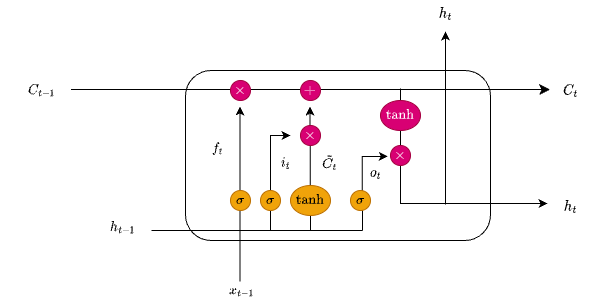

- $C_{t-1}$: previous cell state
- $x_t$: input at time $t$
- $\sigma$: sigmoid layer
- $\tanh$: tanh layer

An noticeable difference between LSTM and RNN is the gates in LSTM. A gate controls the information of LSTM by adding or removing the information of the cell state. It consists of a sigmoid layer and a pointwise multiplication operation.

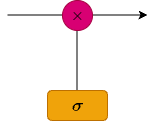

We first determine what information we want to keep and discard. The forget gate layer takes input $h_{t-1}$ and $x_t$ and outputs a probability for each component of the previous cell state $C_{t-1}$. The symbol $[a,b]$ means "concatenate to vectors $a$ and $b$". If $f_t=0$, then the previous information is totally eliminated; if $f_t=1$, it means keep all the information.

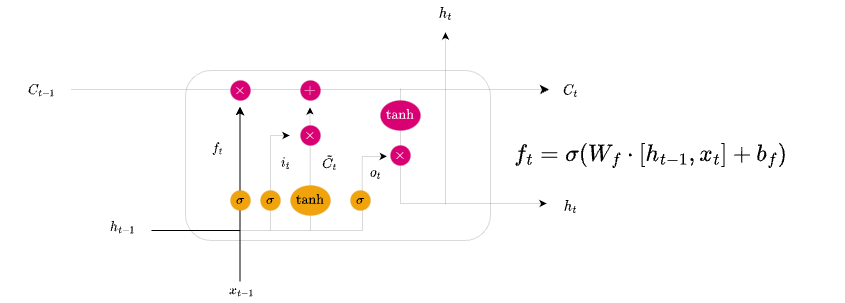

Next, we decide what information to store in the cell state. The sigmoid layer is called the "input gate layer" that decides what information to stay. The $\tanh$ layer creates a candidate added to the cell state.

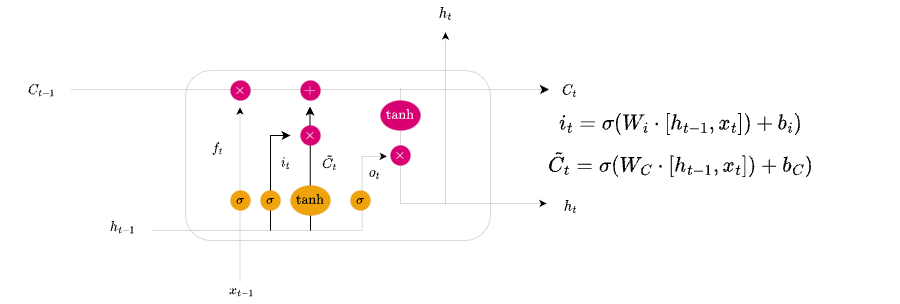

Then, we update the cell state by the formula:
$$
C_t = f_t*C_{t-1}+i_t*\tilde{C_t}.
$$
$C_t$ is the previous cell state, which can be viewd as the "old information". $\tilde{C_t}$ is the "new information" at the current time. The factor $f_t$ determines what "old information" to stay, while the factor $i_t$ determines what "new information" to stay.

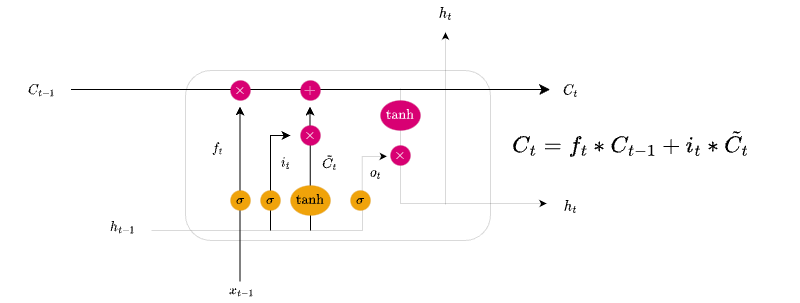

Last, we determine the output of the cell. The sigmoid layer outputs the probability $o_t$ that decides what parts of the cell state to output. The filter $\tanh$ restricts the values of the cell state $C_t$ between -1 and 1. The final output $h_t$ is defined by the the multiplication of $o_t$ and $\tanh(C_t)$
$$
h_t = o_t*\tanh(C_t).
$$

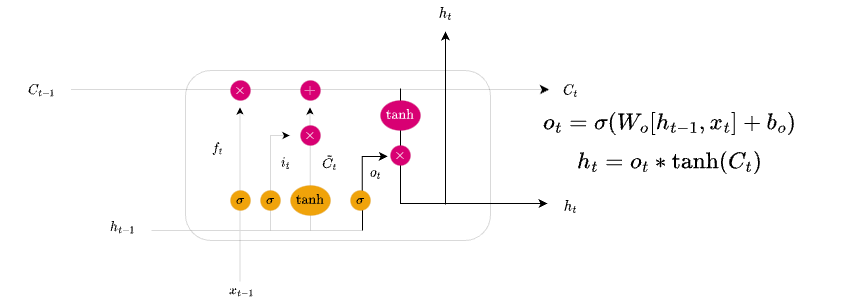

## RNN Implementation
We will build a RNN to classify words. The code is modified from a [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) which also guides the basic preprocessing of NLP data. We will go through the code and give some explanations. 

In [2]:
# Define a function that returns the file names
import glob
def findFiles(path): 
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [4]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII      
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
import os
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(n_categories)
print(category_lines['Italian'])
print(category_lines['Italian'][:5])

18
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni', 'Abatescianni', 'Abba', 'Abbadelli', 'Abbascia', 'Abbatangelo', 'Abbatantuono', 'Abbate', 'Abbatelli', 'Abbaticchio', 'Abbiati', 'Abbracciabene', 'Abbracciabeni', 'Abelli', 'Abello', 'Abrami', 'Abramo', 'Acardi', 'Accardi', 'Accardo', 'Acciai', 'Acciaio', 'Acciaioli', 'Acconci', 'Acconcio', 'Accorsi', 'Accorso', 'Accosi', 'Accursio', 'Acerbi', 'Acone', 'Aconi', 'Acqua', 'Acquafredda', 'Acquarone', 'Acquati', 'Adalardi', 'Adami', 'Adamo', 'Adamoli', 'Addario', 'Adelardi', 'Adessi', 'Adimari', 'Adriatico', 'Affini', 'Africani', 'Africano', 'Agani', 'Aggi', 'Aggio', 'Agli', 'Agnelli', 'Agnellutti', 'Agnusdei', 'Agosti', 'Agostini', 'Agresta', 'Agrioli', 'Aiello', 'Aiolfi', 'Airaldi', 'Airo', 'Aita', 'Ajello', 'Alagona', 'Alamanni', 'Albanesi', 'Albani', 'Albano', 'Alberghi', 'Alberghini', 'Alberici', 'Alberighi', 'Albero', 'Albini', 'Albricci', 'Albrici', 'Alcheri', 'Aldebrandi', 'Alderisi', 'Alduino', 'Alemagna', 'A

We use **one-hot** vectors to encode letters, which only works in small datasets. If your dataset is larget, **word embedding** methods are recommended, e.g. skip-gram, CBOW, since one-hot methods
- consume lots of memory
- omit the association of words.

In [6]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### RNN model

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [8]:
# Demonstration
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9371, -2.8804, -2.9106, -2.8178, -2.9095, -2.9992, -2.8290, -2.9397,
         -2.9374, -2.8254, -2.8845, -2.9630, -2.8570, -2.8500, -2.8269, -2.8157,
         -2.9068, -2.9646]], grad_fn=<LogSoftmaxBackward0>)


In [9]:
# The helper function that returns the greatest value of the output tensor
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Dutch', 15)


In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Nelli
category = French / line = Girard
category = Irish / line = Ciardha
category = Dutch / line = Kool
category = Greek / line = Close
category = Greek / line = Kapsimalles
category = Spanish / line = Vela
category = Vietnamese / line = Tron
category = Chinese / line = Xiao
category = German / line = Dunkle


In [11]:
criterion = nn.NLLLoss()

### Training
- Initialize a zeroed hidden state
- Iterate all the letters in a input text line
    - Keep the hidden state
- Calculate the loss of the final output and the target
- Backpropagate and update parameters
- return the output and loss (to keep track of loss)

In [13]:
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [14]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 1s) 2.4542 Huang / Vietnamese ✗ (Chinese)
10000 10% (0m 3s) 3.1999 Ranks / Polish ✗ (English)
15000 15% (0m 5s) 2.3393 Parasyuk / Polish ✗ (Russian)
20000 20% (0m 7s) 0.5082 Valkovoy / Russian ✓
25000 25% (0m 9s) 1.5932 Basurto / Portuguese ✗ (Spanish)
30000 30% (0m 11s) 2.0668 Pfaff / Arabic ✗ (German)
35000 35% (0m 12s) 0.9123 Poggio / Italian ✓
40000 40% (0m 14s) 0.7271 Basurto / Portuguese ✓
45000 45% (0m 16s) 1.5435 Miller / Scottish ✓
50000 50% (0m 18s) 0.5630 Liu / Chinese ✓
55000 55% (0m 20s) 0.8980 Sun / Chinese ✗ (Korean)
60000 60% (0m 22s) 4.4246 Tsoumada / Japanese ✗ (Greek)
65000 65% (0m 24s) 2.4548 Houtum / Arabic ✗ (Dutch)
70000 70% (0m 26s) 1.3571 Rome / French ✓
75000 75% (0m 27s) 0.6649 Hajicek / Czech ✓
80000 80% (0m 29s) 0.7975 Phi / Vietnamese ✓
85000 85% (0m 31s) 0.8842 Dan / Chinese ✓
90000 90% (0m 33s) 4.2886 Haanrath / Irish ✗ (Dutch)
95000 95% (0m 35s) 2.3155 Mokhnatkin / Arabic ✗ (Russian)
100000 100% (0m 37s) 6.0606 Montague / French ✗ (English)


### Plot the results


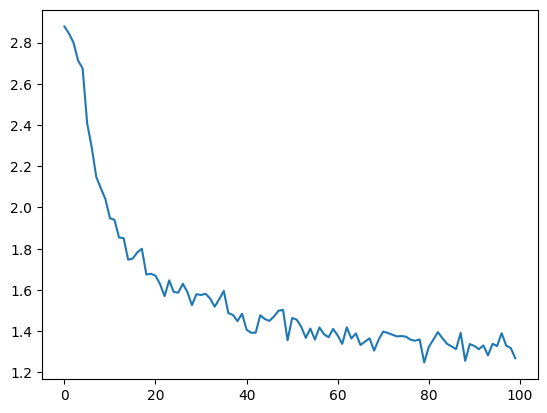

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/var/folders/l_/hv8jcrtx21gbrkh5jzb7xfz80000gn/T/ipykernel_27331/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/l_/hv8jcrtx21gbrkh5jzb7xfz80000gn/T/ipykernel_27331/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


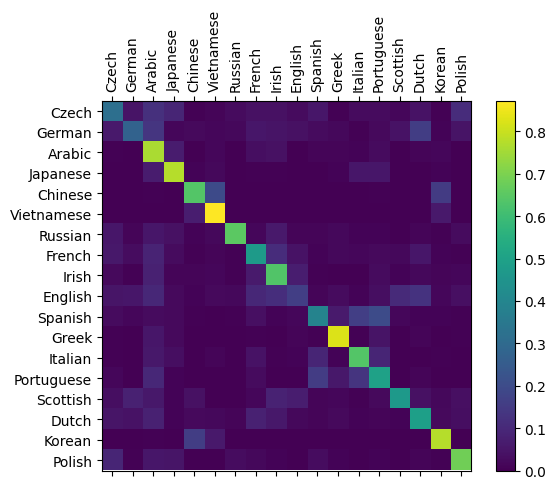

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# No update, just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Running on user input
This part is so cool!

In [17]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.38) Czech
(-1.50) Russian
(-3.20) English

> Jackson
(-0.05) Scottish
(-4.07) English
(-4.39) French

> Satoshi
(-1.03) Japanese
(-1.46) Italian
(-2.13) Arabic


## References
- https://mmuratarat.github.io/2019-02-07/bptt-of-rnn
- https://arxiv.org/pdf/1211.5063.pdf
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://www.jefkine.com/general/2018/05/21/2018-05-21-vanishing-and-exploding-gradient-problems/
- https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html